#Deep learning for optical imaging

###Project: Droplet Impact - Mapping Interferometry to TIR Images (Filtered Data)

by: Ramin Kaviani

Date: 18/03/2021

#Step 0
Reading the compressed file.

In [1]:
# Import python libraries

import h5py   # HDF5 data file management library

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils') 

from sklearn.model_selection import train_test_split
from keras.models import load_model


import tensorflow as tf
import random
import skimage
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib


import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pickle

!cat /proc/cpuinfo
!cat /proc/meminfo
device_lib.list_local_devices()
!nvidia-smi
!nvcc -V
!/usr/bin/python3 --version
tf.__version__



processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

'2.4.1'

In [2]:
# Mount google drive to virtual machine using an authorization code



from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# function to display a grayscale image

magConstant=70000.0 # 66000 # Fatal
offsertConstant = 100.0

def show_image_gray(image, title):

    import matplotlib.pyplot as plt    
    
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()
    
    return

def plot_x(y, id):
  ix=28
  iy=112
  a=np.zeros( (ix*iy,1))
  for n in range(ix*iy):
    a[n]=y[id][n]
  a=a.reshape(ix, iy)
  plt.imshow(a,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()

def plot_xx(y, id):
  ix=28
  iy=112
  iz=3
  a=np.zeros( (ix*iy*iz,1))
  for n in range(ix*iy*iz):
    a[n]=y[id][n]
  a=a.reshape(ix, iy, iz)
  b=a[:,:,1]
  plt.imshow(b,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()

def plot_y(y, id):
  ix=64
  iy=364
  a=np.zeros( (ix*iy,1))
  for n in range(ix*iy):
    a[n]=y[id][n]
  a=a.reshape(ix, iy)
  plt.imshow(a,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()

In [4]:
data_path = '/content/gdrive/My Drive/data/'  

input_data_filename = data_path + 'xa.h5'
output_data_filename = data_path + 'ya.h5'
#output_class_onehot_filename = data_path + 'output_class_onehot.h5'
#output_class_names_filename = data_path + 'output_class_names.npy'

hf = h5py.File(input_data_filename, 'r')
temp = hf.get('x')
input_data1 = np.array(temp)
hf.close()
del temp

hf = h5py.File(output_data_filename, 'r')
temp = hf.get('y')
output_data1 = np.array(temp)
hf.close()


print('input_data_raw : ', input_data1.shape, input_data1.dtype)
print('output_data_raw : ', output_data1.shape, output_data1.dtype)
print()

# Deleting Variables Creating Empty Memory
del temp

input_data_raw :  (364, 64, 17448) uint16
output_data_raw :  (364, 64, 17448) uint16



In [5]:
input_data=np.zeros((input_data1.shape[2],input_data1.shape[1],input_data1.shape[0],1),dtype=input_data1.dtype)
#input_data=np.zeros((input_data1.shape[2],input_data1.shape[1],input_data1.shape[0],3,1),dtype=input_data1.dtype)

"""
for i in range(input_data1.shape[0]):
  for j in range(input_data1.shape[1]):
    for k in range(input_data1.shape[2]):
      input_data[k,j,i,0]=input_data1[i,j,k]
      
for i in range(output_data1.shape[0]):
  for j in range(output_data1.shape[1]):
    for k in range(output_data1.shape[2]):
      output_data[k,j,i,0]=output_data1[i,j,k]
"""      

tmp1 = np.zeros((input_data1.shape[0],input_data1.shape[2]),dtype=input_data1.dtype)      
for j in range(input_data1.shape[1]):
  tmp1= input_data1[:,j,:]
  transpose_tmp1=np.transpose(tmp1)
  input_data[:,j,:,0] = transpose_tmp1
#  input_data[:,j,:,0,0] = transpose_tmp1
#  input_data[:,j,:,1,0] = transpose_tmp1
#  input_data[:,j,:,2,0] = transpose_tmp1
  
del tmp1 
del input_data1

output_data=np.zeros((output_data1.shape[2],output_data1.shape[1],output_data1.shape[0],1),dtype=output_data1.dtype)

tmp2 = np.zeros((output_data1.shape[0],output_data1.shape[2]),dtype=output_data1.dtype)      
for j in range(output_data1.shape[1]):
  tmp2= output_data1[:,j,:]
  output_data[:,j,:,0] = np.transpose(tmp2)

print('input_data : ', input_data.shape, input_data.dtype)
print('output_data : ', output_data.shape, output_data.dtype)


n_data_items = input_data.shape[0]
input_xsize = input_data.shape[1]
input_ysize = input_data.shape[2]
#n_input_channels = input_data.shape[3]
#n_output_classes = output_class_onehot.shape[1]

output_xsize = output_data.shape[1]
output_ysize = output_data.shape[2]

print('total number of data items : ', n_data_items)
print('input size [pixels] : ', input_xsize, 'x', input_ysize)
#print('number of input channels : ', n_input_channels)
#print('number of output classes : ', n_output_classes)
print()

# Deleting Variables Creating Empty Memory

del output_data1
del tmp2


input_data :  (17448, 64, 364, 1) uint16
output_data :  (17448, 64, 364, 1) uint16
total number of data items :  17448
input size [pixels] :  64 x 364



In [6]:
pickle.dump( input_data, open( "/content/gdrive/My Drive/data/input_data.p", "wb" ) )
pickle.dump( output_data, open( "/content/gdrive/My Drive/data/output_data.p", "wb" ) )

#input_data = pickle.load (open( "/content/gdrive/My Drive/data/input_data.p", "rb" ) )
#output_data = pickle.load( open( "/content/gdrive/My Drive/data/output_data.p", "rb" ) )

n_data_items = input_data.shape[0]
input_xsize = input_data.shape[1]
input_ysize = input_data.shape[2]
input_zsize = 1
# input_zsize = 3

output_xsize = output_data.shape[1]
output_ysize = output_data.shape[2]


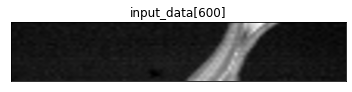

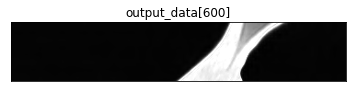

In [7]:
# show example of dataset

data_item = 600
#data_item = 2000
#show_image_gray(input_data[data_item, :, : , 1, 0],  \
#                title='input_data[' + str(data_item) + ']')

show_image_gray(input_data[data_item, :, : , 0],  \
                title='input_data[' + str(data_item) + ']')

show_image_gray(output_data[data_item, :, :, 0],  \
                title='output_data[' + str(data_item) + ']')

In [8]:
# Split data set into [test] and [train+valid] subsets using sklearn train_test_split function

data_set_test_trainvalid_ratio = 0.05 # 0.05 0.3 0.05 0.05
data_split_state = None   # integer (usually 42) or None for random split on each call

print('test:[train+valid] split ratio : ', data_set_test_trainvalid_ratio)
print('data_split_state : ', data_split_state)
print()

input_trainvalid, input_test, output_trainvalid, output_test =  \
    train_test_split(input_data, output_data, \
                     test_size=data_set_test_trainvalid_ratio, random_state=data_split_state)

#output_class_test=np.argmax(output_data_test,1)
#print(output_class_test)

print('input_data : ', input_data.shape, input_data.dtype)
print('input_trainvalid : ', input_trainvalid.shape, input_trainvalid.dtype)
print('input_test : ', input_test.shape, input_test.dtype)
print()
print('output_data : ', output_data.shape, output_data.dtype)
print('output_trainvalid : ', output_trainvalid.shape, output_trainvalid.dtype)
print('output_test : ', output_test.shape, output_test.dtype)

print('output_data_test : ', output_test.shape, output_test.dtype)

# Deleting Variables Creating Empty Memory # Lets keep them
del input_data
del output_data

test:[train+valid] split ratio :  0.05
data_split_state :  None

input_data :  (17448, 64, 364, 1) uint16
input_trainvalid :  (16575, 64, 364, 1) uint16
input_test :  (873, 64, 364, 1) uint16

output_data :  (17448, 64, 364, 1) uint16
output_trainvalid :  (16575, 64, 364, 1) uint16
output_test :  (873, 64, 364, 1) uint16
output_data_test :  (873, 64, 364, 1) uint16


In [9]:
x_trainvalid= (input_trainvalid.reshape((len(input_trainvalid), np.prod(input_trainvalid.shape[1:]))) + offsertConstant)  / magConstant
#x_test= input_test.reshape((len(input_test), np.prod(input_test.shape[1:]))) / magConstant
del input_test

y_trainvalid = (output_trainvalid.reshape((len(output_trainvalid), np.prod(output_trainvalid.shape[1:]))) + offsertConstant) / magConstant
# y_test = output_test.reshape((len(output_test), np.prod(output_test.shape[1:])))  / magConstant
del output_test

print('x_trainvalid : ', x_trainvalid.shape, x_trainvalid.dtype)
#print('x_test : ', x_test.shape, x_test.dtype)
print()
print('y_trainvalid : ', y_trainvalid.shape, y_trainvalid.dtype)
#print('y_test : ', y_test.shape, y_test.dtype)

# Deleting Variables Creating Empty Memory
#
#
#del input_test
#
del x_trainvalid # no need to plot
del output_trainvalid # free memory


x_trainvalid :  (16575, 23296) float64

y_trainvalid :  (16575, 23296) float64


In [10]:
print(np.amax(y_trainvalid))
print(np.amin(y_trainvalid))


# show example of dataset

data_item = 8000
#plot_xx(x_trainvalid,data_item)
#plot_y(y_trainvalid,data_item)



0.9376428571428571
0.0014285714285714286


#Design Network
Optimizing the VCC CNN:






* Compiling the network model *

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 364, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 364, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 364, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 182, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 182, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 182, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)          

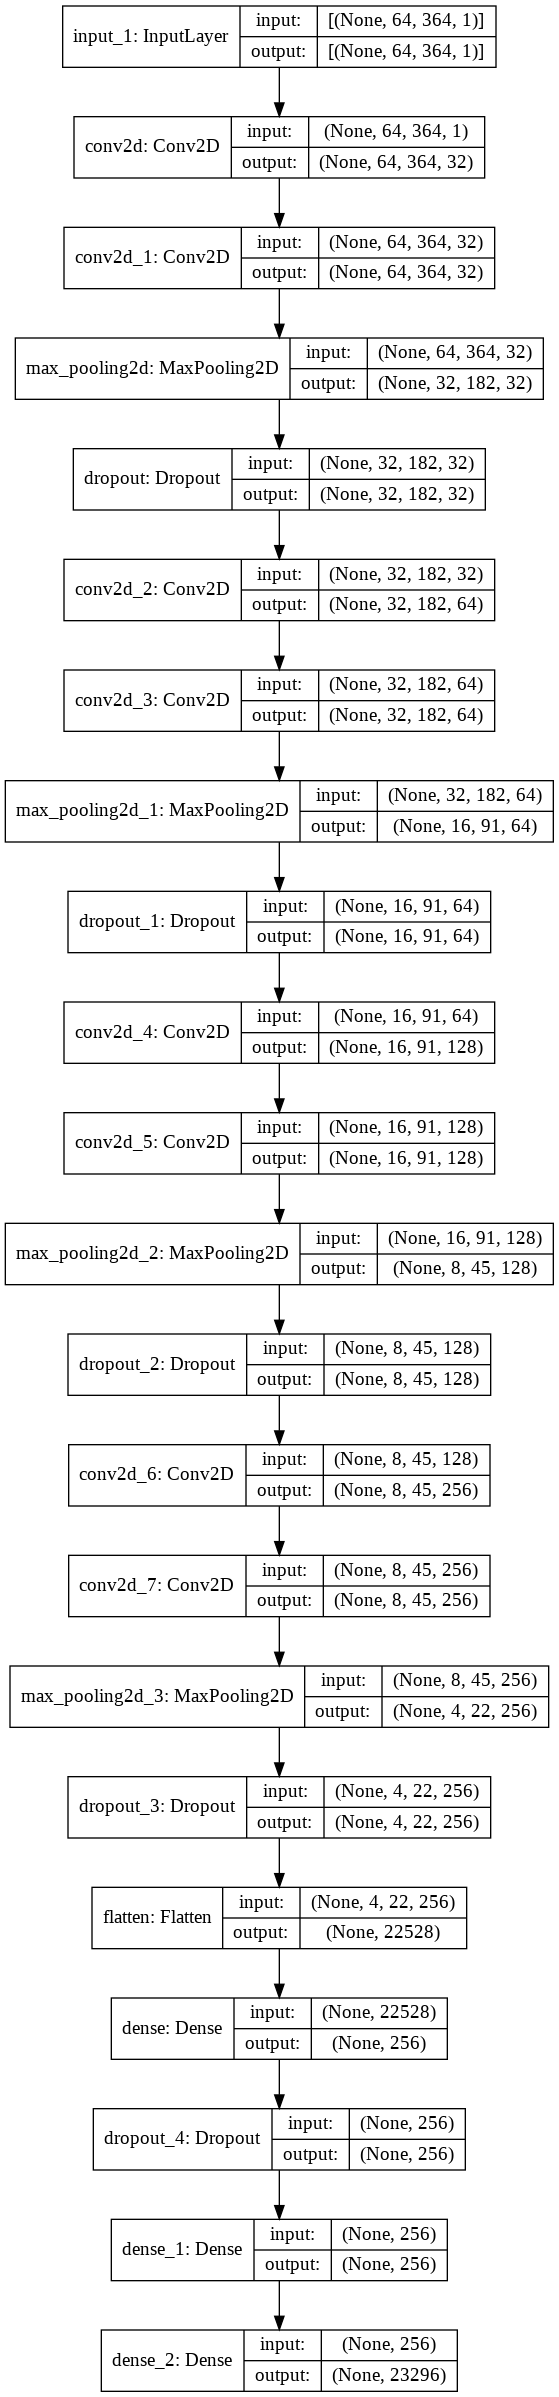

In [11]:
optimizer_type = tf.keras.optimizers.Adam(lr=0.0005)  # optimisation algorithm: SGD stochastic gradient decent 
loss = 'mean_squared_error'  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_absolute_error'] # categorical_accuracy  # network accuracy metric to be determined after each epoch ['accuracy'] mean_absolute_error
dropout_ratio = 0.12  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 2.0/18.0  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 800  # maxmimum number of epochs to be iterated 400 500 1100 1600 3000 80 
batch_size = 100   # batch size for the training data set 500
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
num_hidden_nodes = 2*256  # number of nodes in hidden fully connected layer # 256 4*256 

input_shape = (input_xsize,input_ysize,input_zsize )
inputs = Input(shape=input_shape)
  
conv1 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
conv1_ = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv1)
pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_)
drop1 = Dropout(dropout_ratio)(pool1)
  
  
conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(drop1)
conv2_ = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv2)
pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_)
drop2 = Dropout(dropout_ratio)(pool2)
  
  
conv3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(drop2)
conv3_ = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv3)
pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_)
drop3 = Dropout(dropout_ratio)(pool3)


conv4 = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(drop3)
conv4_ = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv4)
pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_)
drop4 = Dropout(dropout_ratio)(pool4)

pool4_flat = Flatten()(drop4)
dense = Dense(256, activation='relu')(pool4_flat)
drop5 = Dropout(dropout_ratio)(dense)
dense_ = Dense(256, activation='relu')(drop5)

logits = Dense(output_xsize*output_ysize, activation='relu')(dense_ )

print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs, outputs=logits)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

# display a summary of the compiled neural network

print(model.summary())  
print()

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')



In [ ]:
print('* Training the compiled network *')
print()

history = model.fit(input_trainvalid,  y_trainvalid, \
                    batch_size=batch_size, \
                    epochs=max_epochs, \
                    validation_split=validtrain_split_ratio, \
                    shuffle=batch_shuffle)
print()
print('Training completed')
print()

model.save('/content/gdrive/My Drive/data/modelstructure.h5')



* Training the compiled network *

Epoch 1/800
148/148 [==============================] - 90s 246ms/step - loss: 19.5037 - mean_absolute_error: 0.9084 - val_loss: 0.2441 - val_mean_absolute_error: 0.3275
Epoch 2/800
148/148 [==============================] - 32s 216ms/step - loss: 0.2043 - mean_absolute_error: 0.2991 - val_loss: 0.2165 - val_mean_absolute_error: 0.3078
Epoch 3/800
148/148 [==============================] - 32s 214ms/step - loss: 0.1769 - mean_absolute_error: 0.2756 - val_loss: 0.1862 - val_mean_absolute_error: 0.2797
Epoch 4/800
148/148 [==============================] - 31s 213ms/step - loss: 0.1513 - mean_absolute_error: 0.2493 - val_loss: 0.1555 - val_mean_absolute_error: 0.2499
Epoch 5/800
148/148 [==============================] - 32s 214ms/step - loss: 0.1284 - mean_absolute_error: 0.2238 - val_loss: 0.1463 - val_mean_absolute_error: 0.2434
Epoch 6/800
148/148 [==============================] - 32s 213ms/step - loss: 0.1130 - mean_absolute_error: 0.2044 - val_los

In [ ]:
del input_trainvalid
del y_trainvalid

In [ ]:

##model.save('/content/gdrive/My Drive/data/modelstructure.h5')
#model = keras.models.load_model('/content/gdrive/My Drive/data/modelstructure.h5')
# better use local Test11.pyd and ignore the rest of this sheet

In [ ]:

input_data = pickle.load (open( "/content/gdrive/My Drive/data/input_data.p", "rb" ) )
output_data = pickle.load( open( "/content/gdrive/My Drive/data/output_data.p", "rb" ) )

print('input_data : ', input_data.shape, input_data.dtype)
print('output_data : ', output_data.shape, output_data.dtype)

the_length = 2000 # 4362
#input_data = input_data[1:the_length,:,:,:,:]
input_data = input_data[1:the_length,:,:,:] 
output_data = output_data[0:the_length,:,:,:]

print('input_data : ', input_data.shape, input_data.dtype)
print('output_data : ', output_data.shape, output_data.dtype)

n_data_items = input_data.shape[0]
input_xsize = input_data.shape[1]
input_ysize = input_data.shape[2]
input_zsize = 1 # 3

output_xsize = output_data.shape[1]
output_ysize = output_data.shape[2]


In [ ]:
print("Starting prediction");
predict_data = model.predict(input_data)
# del model
# del input_data

print("Prediction Done.")
predict_data_i=(predict_data*magConstant - offsertConstant).astype('uint16') 
#print("Multip Done.")
#predict_data_i = predict_data.astype('uint16') 
del predict_data
print("Conversion to int Done.")
predict_data_z = predict_data_i.reshape(n_data_items,output_xsize,output_ysize) 
del predict_data_i


print('predict_data_z : ', predict_data_z.shape, predict_data_z.dtype)


In [ ]:
pickle.dump( predict_data_z, open( "/content/gdrive/My Drive/data/predict_data_z.p", "wb" ) )

hf = h5py.File('/content/gdrive/My Drive/data/z.h5', 'w')
hf.create_dataset('z', data=predict_data_z)
hf.close()


In [ ]:
#hf.close()
#del predict_data

print(predict_data_z.shape,predict_data_z.dtype)

data_item = 1400

#show_image_gray(input_data[data_item, :, :, 1, 0],  \
#                title='Network input [' + str(data_item) + ']')
show_image_gray(input_data[data_item, :, :, 0],  \
                title='Network input [' + str(data_item) + ']')


show_image_gray(output_data[data_item, :, :, 0],  \
                title='Target TIR Image[' + str(data_item) + ']')
#plot_y(predict_data,data_item)
show_image_gray(predict_data_z[data_item, :, :],  \
                title='Network output [' + str(data_item) + ']')
#show_image_gray(output_data[data_item-2, :, :, 0],  \
#                title='predicted_data[' + str(data_item) + ']')

In [ ]:
#del model
#del input_data
#del output_data
#del predict_data_z